## Layout

A layout $L = (s_1, ..., s_k) : (d_1, ..., d_k)$ maps coordinates $\mathbf{c} = (c_1, \dots, c_k)$ to an index $p \in \mathbb{N}$:
$$
p = L(\mathbf{c}) = \sum_{i=1}^k c_i \cdot d_i = \sum_{i=1}^k L_i(c_i)
$$
where $k$ is called the *rank* of the layout, and the $i$ iterates through each dimension or *mode* of $L$.
The RHS defines a "sub-layout" at mode $i$ as $L_i = s_i:d_i$ where $s_i$ defines the domain and $d_i$ is a mapping stride.

> This notebook will use [./layout.py](layout.py) (a simplified implementation from reference [1, 2, 3, 4]) to illustrate certain basic layout algebra operations.
In these programs, we use `shape` and `stride` to name layout features $s$ and $d$, besides, a layout’s shape and stride tuples must be *congruent*, that is, the two "tuples" need to have the same hierarchical structure.

An overlapping layout looks like this (assume $\forall i, d_i \le d_{i+1}$, a layout overlaps when $\exists j: d_{j+1} < s_j d_j$ and $d_{j+1}$ is a multiple of $d_j$):

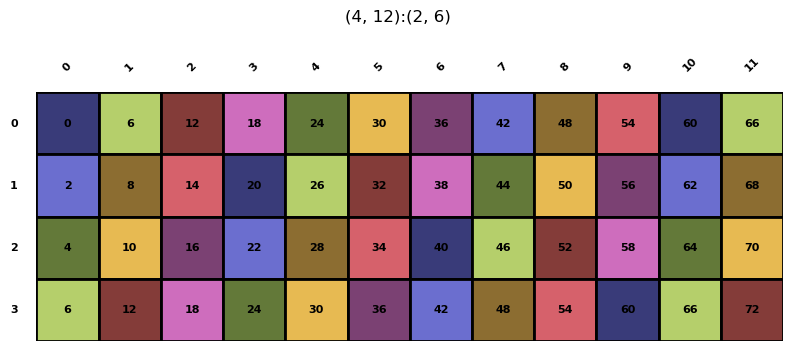

In [67]:
from layout import Layout
A = Layout(shape=(4, 12), stride=(2, 6)).visualize()

A non-overlapping layout (because $8 \ge 2 \times 4$):

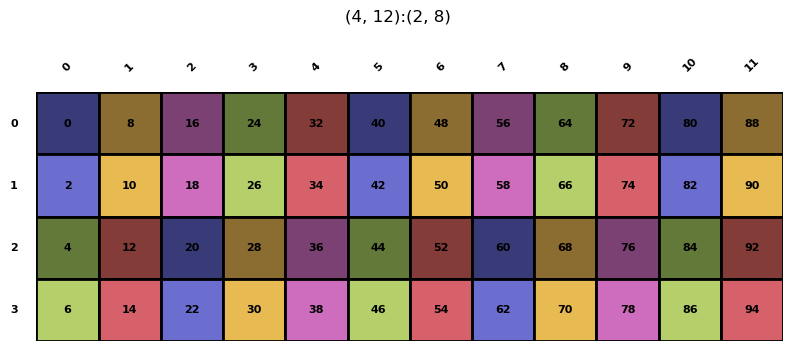

In [62]:
A = Layout(shape=(4, 12), stride=(2, 8)).visualize()

In [63]:
print("domain and co-domain:", A.size(), A.cosize()) # these two are inequal because layout A is non-contiguous here.

domain and co-domain: 48 95


A basic requirement for a layout is usually *non-overlapping*, meaning that if $R_i = \{ L_i(c_i) \}$ be the image of the $i$-th dimension, $\forall i \neq j$, we will have $R_i \cap R_j = \{0\}$ (i.e., *trivial Intersection*). 
This property is also named "disjoint", it implies
* Injective
* Reversibility of Addition (so that you can uncover $\mathbf{c}$ from $p$)

A layout without specifying the strides is default to the *colexicographical order*, i.e., a generalized column-major order where the strides are the *prefix products* of its shapes:

(4, 12):(1, 4)

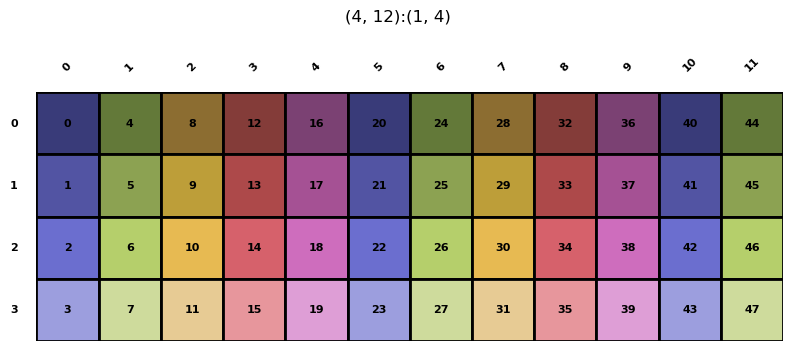

In [66]:
Layout(shape=(4, 12)).visualize()

In a more general case, the tuple can be nested:

((2, 2), (3, 4)):((1, 2), (4, 12))

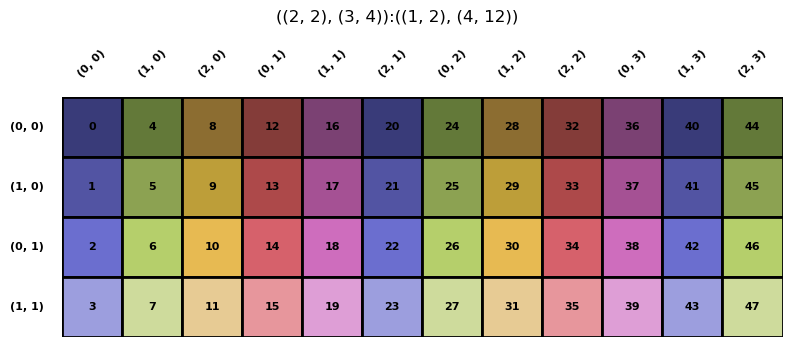

In [64]:
Layout(shape=((2, 2), (3, 4))).visualize()

## Coalesce
`coalesce` simplifies a layout. CuTe (Cutlass Tensor?) [1] defines that it only targets 3 cases:

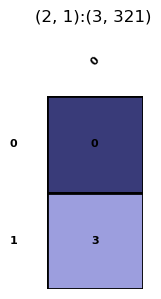

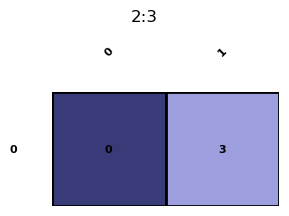

In [3]:
from layout import coalesce
# Case 1: s0:d0  ++  _1:d1  =>  s0:d0
A = Layout.from_string('(2,1):(3,321)').visualize()
B = coalesce(A).visualize()

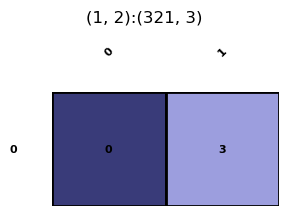

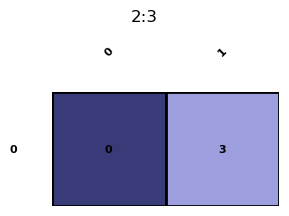

In [4]:
# Case 2: _1:d0  ++  s1:d1  =>  s1:d1
A = Layout.from_string('(1,2):(321, 3)').visualize()
B = coalesce(A).visualize()

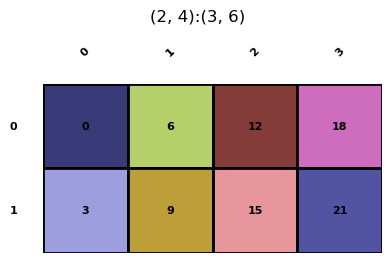

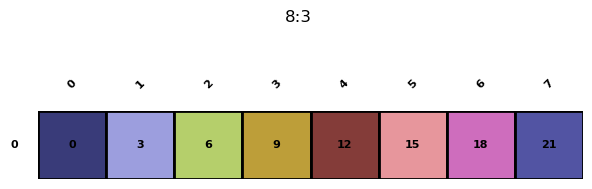

In [5]:
# Case 3: s0:d0  ++  s1:s0*d0  =>  s0*s1:d0
A = Layout.from_string('(2,4):(3,6)').visualize()
B = coalesce(A).visualize()

Note that coalesce does not handle `(4, 2):(6, 3)` because CuTe coalesce is from left to right (e.g., column to row):

(4, 2):(6, 3)

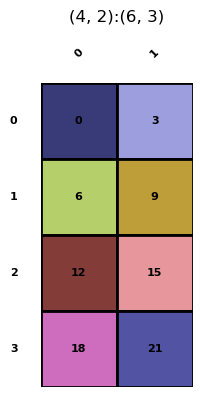

In [69]:
coalesce(Layout.from_string('(4,2):(6,3)')).visualize()

## Composition

As a result of the layout definition and requirement, we have a sum-distributive *composition*, namely,
$$
(A \circ B)(\mathbf{c}) = A \left( \sum_{i} B_i(c_i) \right) = \sum_{i} A(B_i(c_i)) = \sum_{i} (A \circ B_i)(c_i)
$$

Assume $A=A_s:A_d$ and $B_i(c_i) = c \cdot B_d$, then
$$
A(B_i(c_i)) = A(c_i \cdot B_d)
$$
which is essentially to determine a layout that produces every $B_d$-th element of $A$.

An example A / B_stride (so called "dividing out"):
* (3,6,2,8):(w,x,y,z) / 72
* = (ceil[3/72], ceil[6/24], ceil[2/4], ceil[8/2]):(72w, 24x, 4x, 2z)
* = (1, 1, 1, 4):(72w, 24x, 4x, 2z)

The shape of resulting layout should match $B$, hence composition also requires "modding out" shapes:
```python
remain_shape = other.shape
for dim in mode(L):
    new_shape = dividing_out(L, dim)
    new_shape = min(new_shape, remain_shape)
    remain_shape = remain_shape // new_shape
```

In the following, we will show some visualized examples:

+ min(6/2, 9):5*2
+ 3:10*1



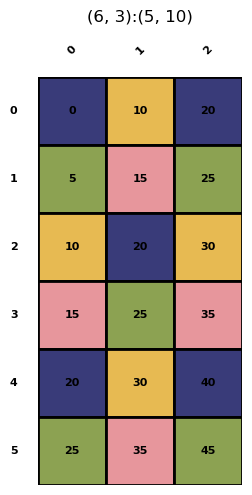

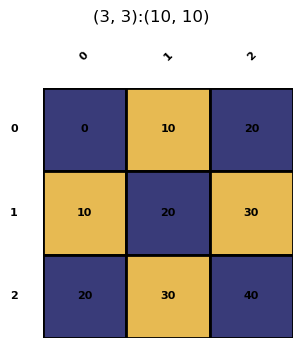

In [7]:
_ = Layout.from_string('(6,3):(5,10)').visualize().composite(Layout.from_string('9:2'), verbose=True).visualize()

+ min(6/3, 4):8*3
+ 2:5*1

+ min(6/2, 3):8*2
+ 1:5*1



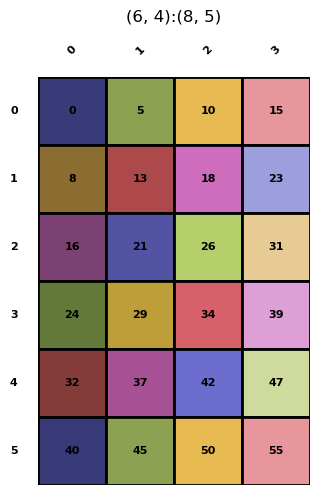

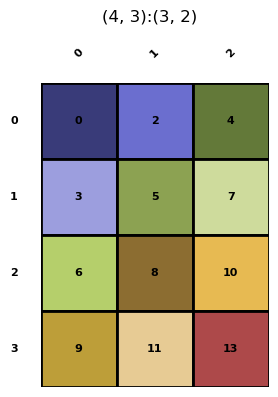

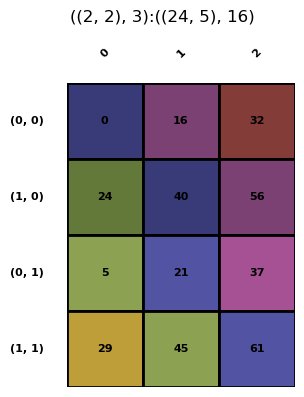

In [17]:
_ = Layout.from_string('(6,4):(8,5)').visualize().composite(Layout.from_string('(4,3):(3,2)').visualize(), verbose=True).visualize()

And by-mode composition (here, the right operand is often denoted by a sequence of *mode pairs* or *tilers*, i.e., `<3:4, 8:2>`):

+ 3:59*4

+ min(4/2, 8):13*2
+ 4:1*1



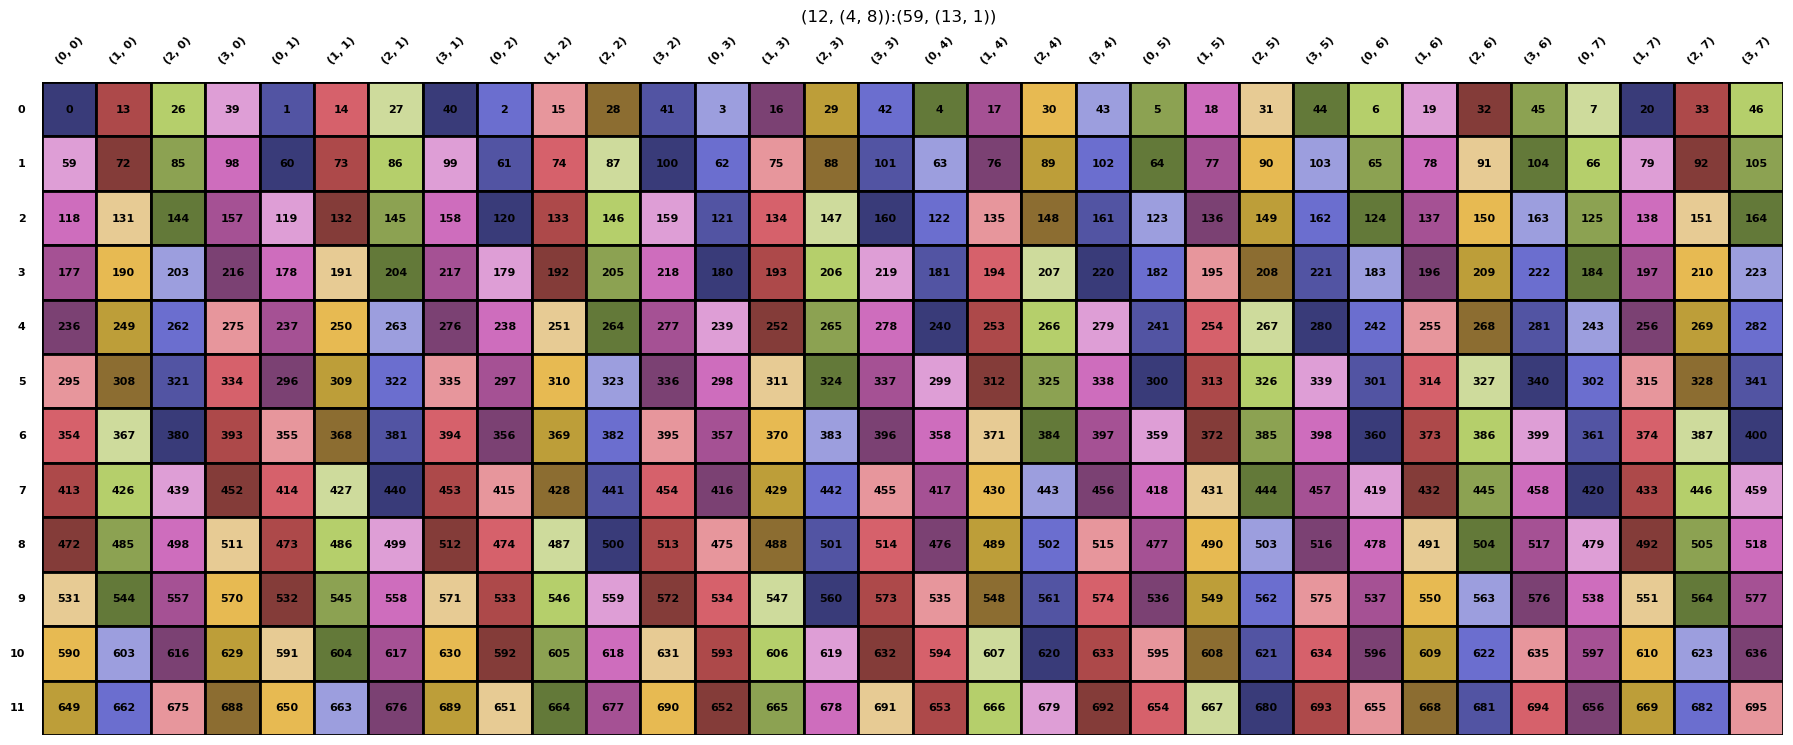

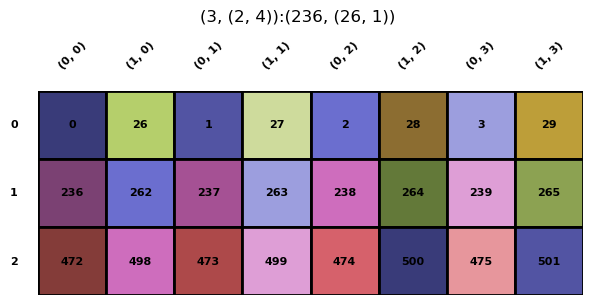

In [18]:
_ = Layout.from_string('(12, (4, 8)):(59, (13, 1))').visualize().composite(Layout.from_string('(3,8):(4,2)'), by_mode=True, verbose=True).visualize()

And by-mode composition by `<3, 8>`:

+ 3:59*1

+ min(4/1, 8):13*1
+ 2:1*1



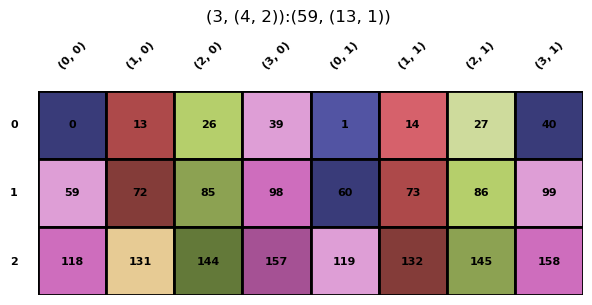

In [19]:
_ = Layout.from_string('(12, (4, 8)):(59, (13, 1))').composite(Layout.from_string('(3,8):(1,1)'), by_mode=True, verbose=True).visualize()

## Complement
The complement of a layout attempts to find another layout that represents the leftovers in the targeted `co-domain` size, i.e., `cotarget`.

Below are CuTe examples [1] with all `cotarget=24`, give the formula:

$$
\operatorname{complement}_{24}(L) = 
\Big( \lceil \frac{d_1}{1} \rceil, \lceil \frac{d_2}{s_1 \cdot d_1} \rceil, \lceil \frac{d_3}{s_2 \cdot d_2} \rceil, ..., \lceil \frac{24}{s_{k-1} \cdot d_{k-1}} \rceil \Big)
:
\Big( 1, s_1 \cdot d_1, s_2 \cdot d_2, ..., s_{k-1} \cdot d_{k-1}\Big)
$$

+ 1/1:1
+ 24/4:4


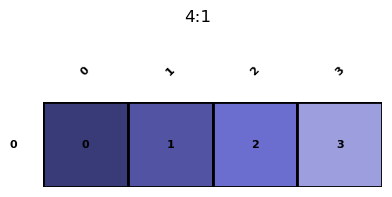

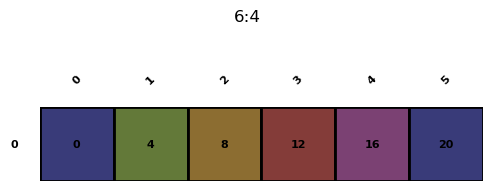

In [20]:
_ = Layout.from_string('4:1').visualize().complement(24, verbose=True).visualize()

+ 4/1:1
+ 24/24:24


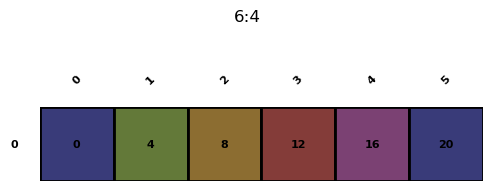

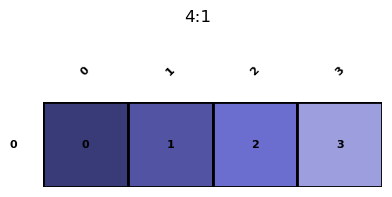

In [21]:
_ = Layout.from_string('6:4').visualize().complement(24, verbose=True).visualize()

+ 1/1:1
+ 4/4:4
+ 24/24:24


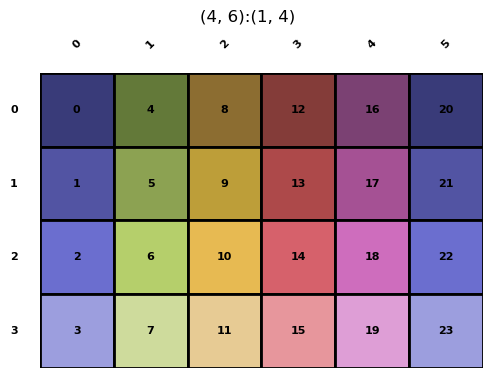

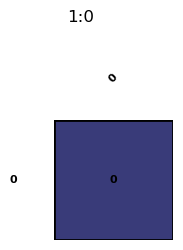

In [22]:
_ = Layout.from_string('(4,6):(1,4)').visualize().complement(24, verbose=True).visualize()

+ 2/1:1
+ 24/8:8


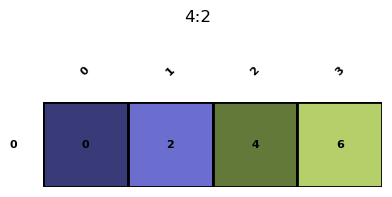

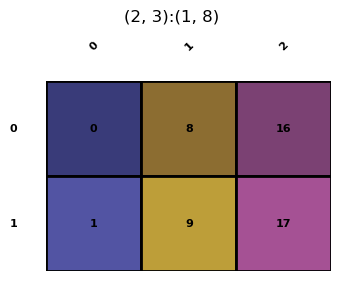

In [23]:
_ = Layout.from_string('4:2').visualize().complement(24, verbose=True).visualize()

+ 1/1:1
+ 6/2:2
+ 24/24:24


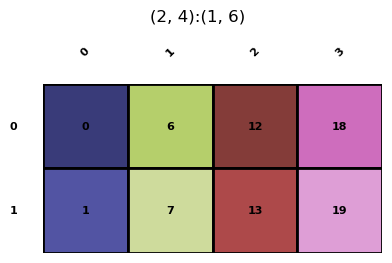

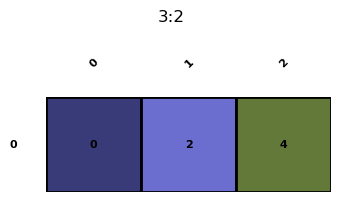

In [24]:
_ = Layout.from_string('(2,4):(1,6)').visualize().complement(24, verbose=True).visualize()

+ 1/1:1
+ 6/2:2
+ 24/12:12


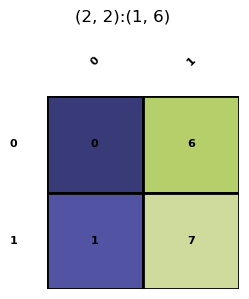

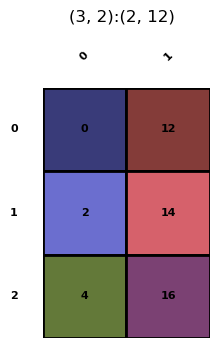

In [25]:
_ = Layout.from_string('(2,2):(1,6)').visualize().complement(24, verbose=True).visualize()

## Next
To be continued in [division](layout_divide.ipynb) and [product](layout_product.ipynb).

## Reference
[1] https://github.com/NVIDIA/cutlass/blob/acb45938e9cb3e4db8c1d75155b63d31791e0e5d/media/docs/cpp/cute/02_layout_algebra.md

[2] https://github.com/NVIDIA/cutlass/blob/acb45938e9cb3e4db8c1d75155b63d31791e0e5d/python/pycute/layout.py

[3] https://docs.modular.com/mojo/kernels/layout/layout

[4] https://github.com/modular/modular/blob/61603e2f4990e65b6c962389a13a1c288d0fb47b/max/kernels/src/layout/layout.mojo

[5] https://docs.modular.com/mojo/manual/layout/layouts/